# Aprendizaje Automático para Datos en Grafos - Laboratorio 4
## Inferencia de topología

En este laboratorio vamos a trabajar en el problema de inferir la topología subyacente de un grafo a partir de datos de observaciones o medidas en los vértices. Supongamos que conocemos los $N$ vértices de un grafo con pesos, pero no cómo se relacionan esos vértices (es decir, no conocemos el conjunto de aristas del grafo ni los pesos de esas aristas). Lo único que podemos observar es una señal o *feature* para cada nodo del grafo, que notaremos como $\mathbf{x}_i \in \mathbb{R}^d$. En términos generales, el problema que abordaremos aquí será el de tratar de estimar la estructura del grafo (las aristas y sus pesos) a partir de las señales observadas.

Nos enfocaremos en tres métodos que intentan resolver este problema de distintas maneras. Los métodos provienen de los siguientes papers:


* ["High-dimensional graphs and variable selection with the Lasso"](https://projecteuclid.org/journals/annals-of-statistics/volume-34/issue-3/High-dimensional-graphs-and-variable-selection-with-the-Lasso), Meinshausen y Bühlmann, 2006
* ["Sparse inverse covariance estimation with the graphical lasso"](https://academic.oup.com/biostatistics/article/9/3/432/224260), Friedman, Hastie y Tibshirani, 2008.
* ["How to learn a graph from smooth signals"](https://arxiv.org/abs/1601.02513), Kalofolias, 2016.

Veremos cómo implementar y aplicar parte de estos métodos. En una primera parte trabajaremos con datos sintéticos, generados a partir de una estructura conocida que intentaremos recuperar.
En la segunda parte trabajaremos con un dataset de imágenes de dígitos, e intentaremos aprender un grafo que los relacione.


In [31]:
# Como siempre, comenzamos por importar las librerías que vamos usar.
# Instalo Graspologic
!pip install graspologic


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [78]:
# Importo librerías y funciones
import networkx as nx
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import torch
import sys
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV
from graspologic.utils import remap_labels

from pathlib import Path

images_folder = Path("lab4/informe/imagenes")
images_folder.mkdir(exist_ok=True, parents=True)

## Inferencia de topología en grafos sintéticos
En esta primera parte trabajaremos con un grafo sintético. Para generarlo, seguiremos el siguiente procedimiento:

a)  Sorteamos $N$ puntos de forma uniforme en el cuadrado $[0,1] \times [0,1]$. Esos serán los vértices de nuestro grafo.

b)  Para cada par de puntos $i$ y $j$ que sorteamos antes, tomamos como peso de la arista $(i,j)$ a $w_{ij} = 0$ si $i=j$ o $w_{ij} = e^{-\frac{d(i,j)}{2\sigma^2}}$ si $i \neq j$, donde $d(i,j)$ es la distancia euclidea en $\mathbb{R}^2$ y $\sigma$ es un parámetro fijo.

c) Nos quedamos solamente con las aristas cuyo peso $w_{ij}$ sea mayor que un número fijo $r>0$ (es decir, hacemos 0 todos los pesos que sean menores que $r$).


1. Escribir una función que, dado un número de vértices $N$ y dos parámetros $\sigma$ y $r$ genere un grafo con pesos con el procedimiento de arriba

In [33]:
# La siguiente función de scikit-learn puede ser de utilidad
from sklearn.metrics.pairwise import euclidean_distances

def generate_random_graph(N, sigma, r):
    # TODO: Implementar esta función que acepta como argumentos un número de
    # vértices N y dos parámetros sigma y r devuelve dos arrays de numpy: uno con
    # las posiciones sorteadas al azar en [0,1]x[0,1] y otro con con los
    # pesos w_{ij} generados con el procedimiento de arriba
    # points = np.zeros((N, 2))
    # weights = np.zeros((N, N))

    points = np.random.rand(N, 2)

    distancias = euclidean_distances(points)

    weights = np.exp(- distancias / (2*sigma**2))
    np.fill_diagonal(weights, val=0) 
    weights = np.where(weights > r, weights, 0)

    return points, weights

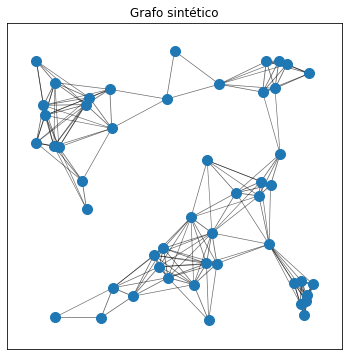

In [34]:
# Fijo estado del random de numpy para reproducibilidad
np.random.seed(34)

# Parámetros del grafo
N = 50
sigma = 0.5
r = 0.6
# Genero pesos
points, weights = generate_random_graph(N,sigma,r)
# Paso a grafo de Networkx
G_synthetic = nx.from_numpy_array(weights)
# Tomo como posiciones del grafo los puntos del [0,1]x[0,1] que sorteé
pos = {node:point for (node,point) in zip(G_synthetic.nodes(),points)}
# Dibujo el grafo
fig,ax = plt.subplots(1,1,figsize=(6, 6))
ax.set_title("Grafo sintético")
edges = G_synthetic.edges()
edge_weights = nx.get_edge_attributes(G_synthetic, "weight")
widths = [edge_weights[edge]*1 for edge in edges]
_ = nx.draw_networkx_nodes(G_synthetic, node_size=100,pos=pos,ax=ax)
_ = nx.draw_networkx_edges(G_synthetic, alpha=0.6, width=widths, pos=pos,ax=ax)
plt.savefig(images_folder / "grafo_sintetico.pdf")

Con la implementación "natural" de la generación del grafo aleatorio, le debería quedar un grafo conexo.
Si lo hacen de otra forma y el grafo sorteado no resulta conexo, modifiquen la semilla de la generación aleatoria hasta que el grafo resultante sea conexo.

Una vez generado el grafo, tomaremos como señal a un vector aleatorio $\mathbf{x} \sim \mathcal{N}(0,L^\dagger)$, donde $L^\dagger$ es la [pseudoinversa](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) del laplaciano $L$ del grafo.

Cada **columna** de la matriz, corresponde a un nodo del grafo.

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


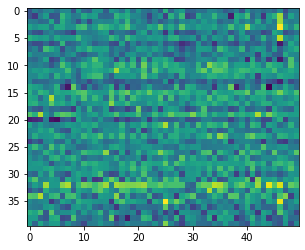

In [35]:
#Generamos datos

n_samples = 40
L = nx.laplacian_matrix(G_synthetic).toarray()
#Le agregamos un pequeño múltiplo de la identidad para evitar el valor propio cero
Ladd = L + 0.1*np.eye(N)
#Y calculamos la pseudoinversa
Lpinv = la.pinv(Ladd)

X = np.random.multivariate_normal(np.zeros(N), Lpinv, size=n_samples)
plt.imshow(X)
plt.savefig(images_folder / "signals_X_pseudoinverse.pdf")
plt.show()


Intentaremos ahora inferir la estructura del grafo, a partir de la matriz de datos.
Observar que si la cantidad de datos (n_samples) es menor que $N$, entonces la matriz de covarianza empírica no es invertible.

Comenzaremos con el Graphical Lasso, para el cual utilizaremos la versión implementada en sklearn.

0.01


/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


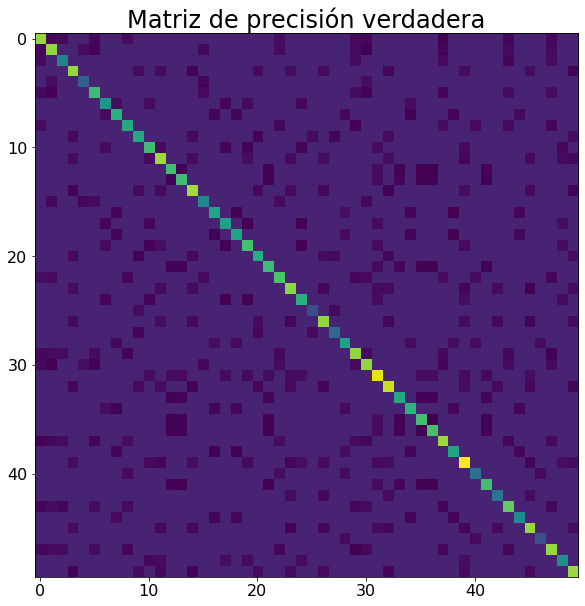

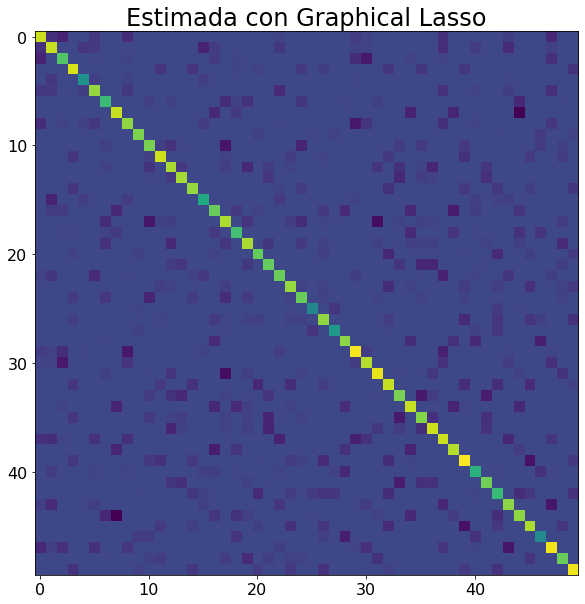

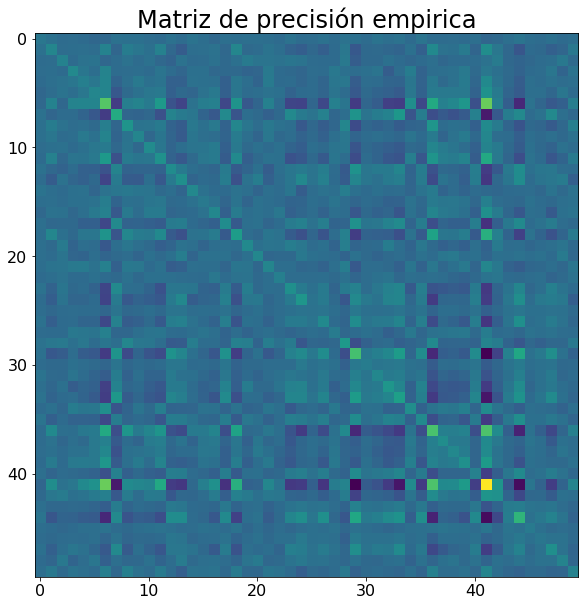

In [36]:
# el método Graphical Lasso tiene un parámetro de penalización (alpha en este código).
# La versión CV elige este alpha utilizando cross-validation

modelCV = GraphicalLassoCV()
modelCV.fit(X)
cov_glassoCV = modelCV.covariance_
prec_glassoCV = modelCV.precision_
print(modelCV.alpha)

emp_cov = np.dot(X.T, X) / n_samples

out_dir = images_folder / "graphical_lasso"
out_dir.mkdir(exist_ok=True)

FONTSIZE = 24
TICK_SIZE = 16
plt.figure(figsize=(10, 10))
plt.imshow(Ladd)
plt.title("Matriz de precisión verdadera", fontsize=FONTSIZE)
plt.tick_params(labelsize=TICK_SIZE)
plt.savefig(out_dir / "true_precision_sample.pdf", pad_inches=0)
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Estimada con Graphical Lasso", fontsize=FONTSIZE)
plt.imshow(prec_glassoCV)
plt.tick_params(labelsize=TICK_SIZE)
plt.savefig(out_dir / "graphical_sample.pdf", pad_inches=0)
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Matriz de precisión empirica", fontsize=FONTSIZE)
plt.imshow(la.pinv(emp_cov))
plt.tick_params(labelsize=TICK_SIZE)
plt.savefig(out_dir / "estimated_sample.pdf", pad_inches=0)
plt.show()


En la celda siguiente, varíe el valor del parámetro $\alpha$ en el Graphical Lasso, y observe cómo repercute en la cantidad de elementos nulos y no nulos de la matriz resultado.

2.   ¿Qué sucede para valores muy grandes de $\alpha$? En esta realización del experimento, ¿a partir de qué valor sucede esto aproxidamente?

Luego de experimentar con el parámetro, elija un valor de $\alpha$ para correr la celda y utilizar el resultado en lo que sigue. Puede ser el valor obtenido en la celda anterior mediante cross-validation, o algún valor cercano cuyo resultado le guste visualmente.



/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:262: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00023484885461527716, tolerance: 6.2869720851812e-05
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:262: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009971442083673843, tolerance: 0.0001992449517641802
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:262: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046795162543333824, tolerance: 0.000234706691583343
  coefs, _, _, _ = cd_fast.enet_

Alpha: 0.01


/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:316: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -4.349e-02
  warnings.warn(


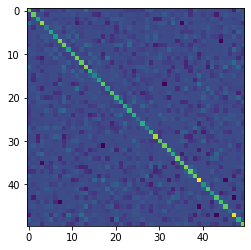

/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:262: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014453984686051413, tolerance: 0.00011393082759823423
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:262: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014240799824210004, tolerance: 0.00012105346488957967
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Alpha: 0.02


/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:316: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.309e-03
  warnings.warn(


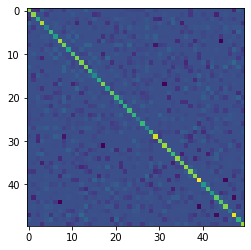

Alpha: 0.05


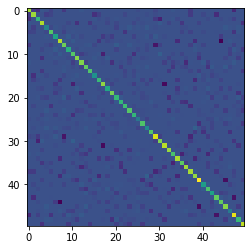

Alpha: 0.1


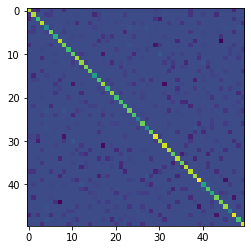

Alpha: 0.5


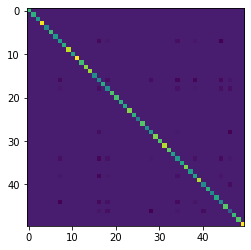

Alpha: 1


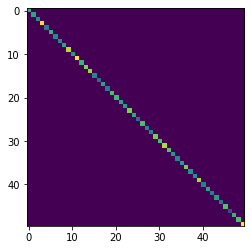

In [65]:
# esta línea setea el valor de alpha al obtenido por cross-validation en la celda anterior.
# Cambie el valor de este parámetro y observe el resultado
alphas = [0.01, 0.02, 0.05, 0.1, 0.5, 1]
for alpha in alphas: 
    model = GraphicalLasso(alpha=alpha)
    model.fit(X)
    cov_glasso_a = model.covariance_
    prec_glasso_a = model.precision_

    emp_cov = np.dot(X.T, X) / n_samples
    print(f"Alpha: {alpha}")
    # plt.figure(figsize=(12, 6))

    # plt.subplot(1,2,1)
    # plt.imshow(Ladd)
    # plt.title("Matriz de precisión verdadera")

    # plt.subplot(1,2,2)
    # plt.title("Estimada con Graphical Lasso")
    # plt.imshow(prec_glasso)

    plt.figure()
    plt.imshow(prec_glasso_a)
    plt.savefig(out_dir / f"graphical_lasso_alpha_{str(alpha).replace('.','_')}.pdf", pad_inches=0)
    plt.show()



In [38]:
alpha = 0.1
model = GraphicalLasso(alpha=alpha)
model.fit(X)
cov_glasso = model.covariance_
prec_glasso = model.precision_

emp_cov = np.dot(X.T, X) / n_samples
print(f"Alpha: {alpha}")

Alpha: 0.1


A continuación probaremos el método de Meinshausen y Bühlmann. Para esto, tendrá que implementar el método, y probarlo en las celdas siguientes.

3.   Implementar el método de Meinshausen y Bühlmann.



In [39]:
# Puede utilizar la función linear_model.Lasso de sklearn
from sklearn import linear_model

def meinshausen(X,alpha,max_iter=1000):
    # TODO: Implementar esta función que acepta como argumentos una matriz de datos
    # (donde cada columna contiene realizaciones correspondientes a cada nodo) y
    # el parámetro de regulización alpha.
    k, p = X.shape
    Xn = normalize(X, axis=0)  # Se normalizan las columnas
    B = np.zeros((p, p))

    #####################
    # Tu código aquí
    #####################
    for j in range(p):
        # saco la j-esima columna porque es la que queremos predecir
        X_j = np.delete(Xn, j, axis=1) 
        y_j = Xn[:, j]
        
        lasso = linear_model.Lasso(alpha=alpha, max_iter=max_iter)
        lasso.fit(X_j, y_j)
        
        coef = lasso.coef_
        B[j, :] = np.insert(coef, j, 0)

    return B

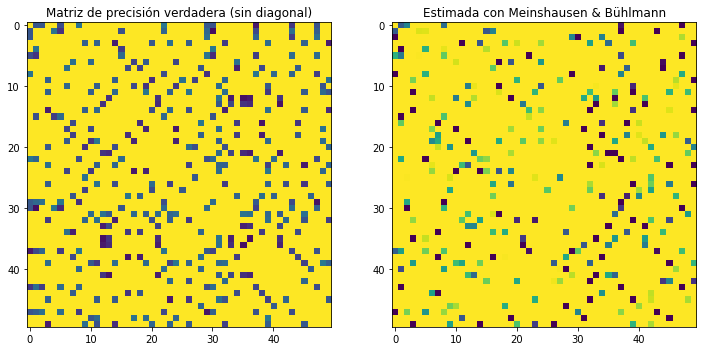

In [71]:
B = meinshausen(X,alpha=0.005)

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.imshow(Ladd - np.diag(np.diag(Ladd)),vmin=-1,vmax=0)
plt.title("Matriz de precisión verdadera (sin diagonal)")

plt.subplot(1,2,2)
plt.title("Estimada con Meinshausen & Bühlmann")
plt.imshow(-B*np.diag(Ladd),vmin=-1,vmax=0)

output_path = Path("lab4/informe/imagenes/meinhausen")
output_path.mkdir(exist_ok=True, parents=True)
plt.savefig(output_path / "matriz_estimada.png", pad_inches=0)


Finalmente probaremos el método de Kalofolias. Primero obtenemos una implementación:

In [41]:
# El método de Kalofolias está implementado en un repositorio de Rodrigo Pena
# Acá bajamos un fork de este repositorio con algunos cambios de nombres de funciones
!git clone https://github.com/marfiori/graph-learning.git
!cp graph-learning/learn_graph.py .
!cp graph-learning/utils.py .
!uv pip install -r graph-learning/requirements.txt pyunlocbox==0.5.2
import learn_graph as lg

fatal: destination path 'graph-learning' already exists and is not an empty directory.
Audited 10 packages in 34ms


4.   Experimente con los parámetros $\alpha$ y $\beta$ del método, hasta obtener una matriz cuya estructura de ceros/no ceros se parezca a la original.



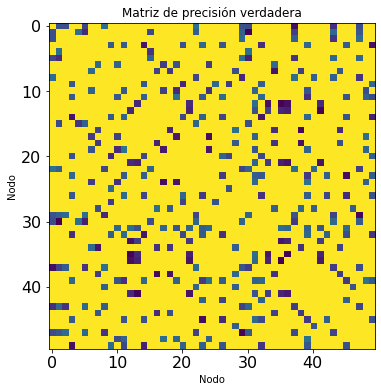

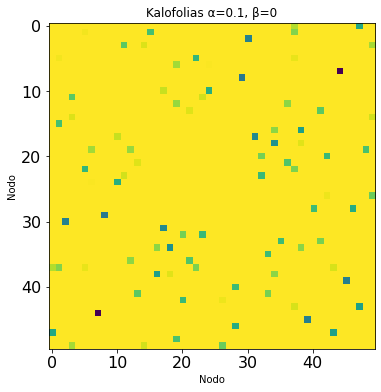

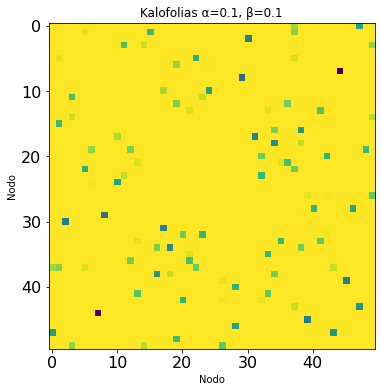

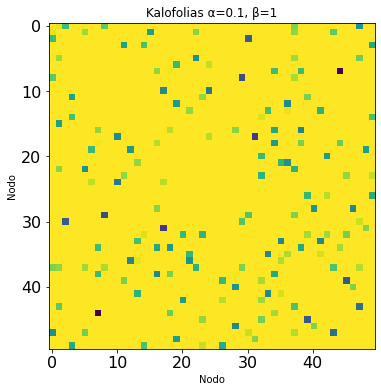

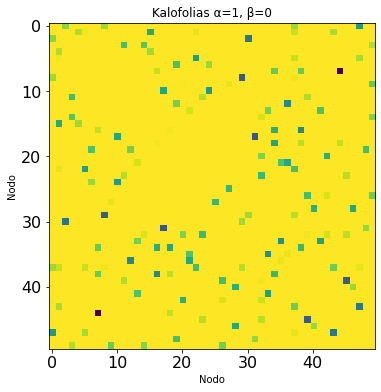

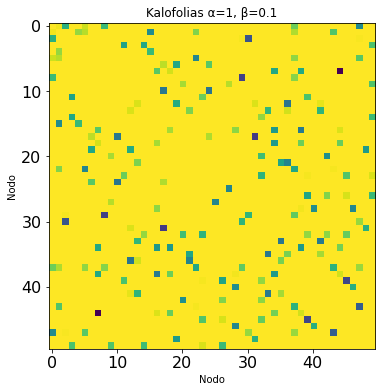

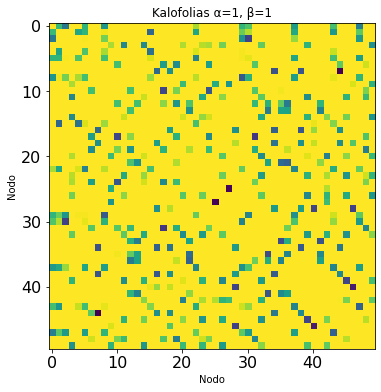

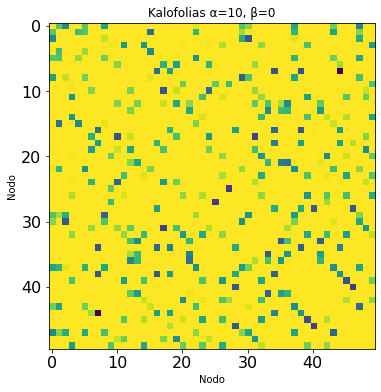

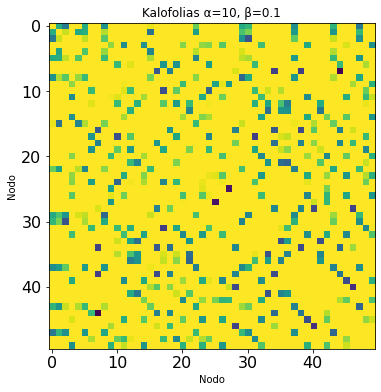

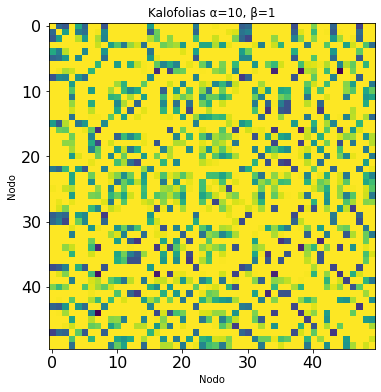

In [85]:
output_folder = images_folder / "kalofolias"
output_folder.mkdir(exist_ok=True)

alphas = [0.1, 1, 10]
betas = [0, 0.1, 1]

# Mostrar la matriz verdadera primero
plt.figure(figsize=(6, 6))
plt.imshow(Ladd - np.diag(np.diag(Ladd)))
plt.title("Matriz de precisión verdadera")
plt.xlabel("Nodo")
plt.ylabel("Nodo")
plt.tick_params(labelsize=TICK_SIZE)
plt.savefig(output_folder / "kalofolias_true.pdf", pad_inches=0)
plt.show()
plt.close()

# Iterar sobre todos los valores de alpha y beta y guardar cada matriz
for alphaKalofolias in alphas:
    for betaKalofolias in betas:
        W = lg.log_degree_barrier(
            normalize(X.T), alpha=alphaKalofolias, beta=betaKalofolias, step=0.1
        )
        plt.figure(figsize=(6, 6))
        plt.imshow(-W)
        plt.title(f"Kalofolias α={alphaKalofolias}, β={betaKalofolias}")
        plt.xlabel("Nodo")
        plt.ylabel("Nodo")
        plt.tick_params(labelsize=TICK_SIZE)
        filename = f"kalofolias_alpha{alphaKalofolias}_beta{betaKalofolias}.pdf"
        plt.savefig(output_folder / filename, pad_inches=0)
        plt.show()
        plt.close()



Veamos cómo quedan los grafos

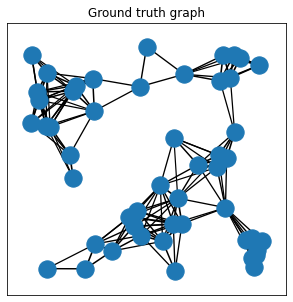

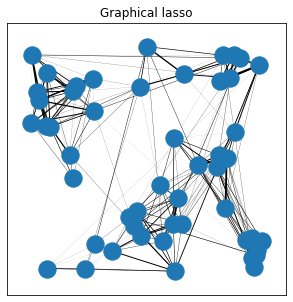

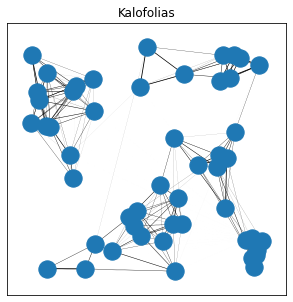

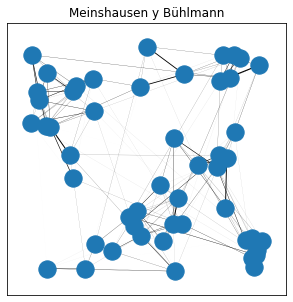

In [95]:
prec_glasso = prec_glassoCV # elegir a mano o con CV

W = lg.log_degree_barrier(
    normalize(X.T), alpha=1, beta=1, step=0.1
)

G_glasso = nx.from_numpy_array(prec_glasso - np.diag(np.diag(prec_glasso)))
G_kalof = nx.from_numpy_array(W)
G_mb = nx.from_numpy_array(B)


output_dir = images_folder / "generated_graph_syntetic/"
output_dir.mkdir(exist_ok=True)
plt.figure(figsize=(5, 5))
plt.title("Ground truth graph")
edges = G_synthetic.edges()
weights = nx.get_edge_attributes(G_synthetic, "weight")
alphas = [weights[edge] * 2 for edge in edges]
_ = nx.draw_networkx_edges(G_synthetic, width=alphas, pos=pos)
_ = nx.draw_networkx_nodes(G_synthetic, pos=pos)
plt.savefig(output_dir / "ground_truth_graph.png", pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
edges = G_glasso.edges()
weights = nx.get_edge_attributes(G_glasso, "weight")
alphas = [weights[edge] * 2 for edge in edges]
_ = nx.draw_networkx_edges(G_glasso, width=alphas, pos=pos)
_ = nx.draw_networkx_nodes(G_glasso, pos=pos)
plt.title("Graphical lasso")
plt.savefig(output_dir / "graphical_lasso.png", pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
edges = G_kalof.edges()
weights = nx.get_edge_attributes(G_kalof, "weight")
alphas = [weights[edge] * 2 for edge in edges]
_ = nx.draw_networkx_edges(G_kalof, width=alphas, pos=pos)
_ = nx.draw_networkx_nodes(G_kalof, pos=pos)
plt.title("Kalofolias")
plt.savefig(output_dir / "kalofolias.png", pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
edges = G_mb.edges()
weights = nx.get_edge_attributes(G_mb, "weight")
alphas = [weights[edge] * 2 for edge in edges]
_ = nx.draw_networkx_edges(G_mb, width=alphas, pos=pos)
_ = nx.draw_networkx_nodes(G_mb, pos=pos)
plt.title("Meinshausen y Bühlmann")
plt.savefig(output_dir / "meinshausen_buhlmann.png", pad_inches=0)
plt.show()



5.  Reflexione sobre el funcionamiento de los métodos a partir de la figura anterior.



# En la segunda parte trabajaremos con los datos de MNIST (dígitos)

Probaremos ahora algunos de los métodos de arriba en un conjunto de datos reales. Trabajaremos con los dígitos de la base MNIST.

In [44]:
# Bajo dataset de imágenes de dígitos de PyTorch
from torchvision import datasets

mnist_data = datasets.MNIST('/tmp/MNIST', train=True, download=True)

Dimensiones de la matriz de features:(2000, 784)


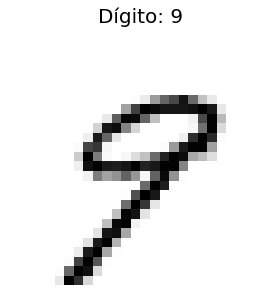

In [45]:
# Me quedo con un subconjunto de las 60000 imágenes
from torch.utils.data import Subset

# Voy a sortear al azar 200 instancias de cada clase
digits = np.arange(10)
num_instances_per_class = 200

subset_idxs = []
for digit in digits:
  # Me fijo cuáles son las muestras que corresponden a este dígito
  digit_idxs = torch.where(mnist_data.targets==digit)[0]
  # Elijo 100 índices al azar
  selected_idxs = np.random.choice(digit_idxs,size=num_instances_per_class,replace=False)
  subset_idxs.extend(selected_idxs)

# Me quedo con el subconjunto de las imágenes que elgí al azar
sampled_mnist_data = Subset(mnist_data,subset_idxs)

# Armo matriz de features
imgs_list = [(np.array(img)/255).astype(np.float32) for img, target_digit in sampled_mnist_data]

# Guardo ground-truth de cada imagen
target_labels = [target_digit for img, target_digit in sampled_mnist_data]

# Paso cada imagen de tamaño 28x28 a un vector de dimensión 784
Xmnist = np.array([img.flatten() for img in imgs_list])

print('Dimensiones de la matriz de features:' + str(Xmnist.shape))

n, _ = Xmnist.shape

# Dibujo una imagen al azar
img_idx = np.random.randint(0,n)
img_fig, img_ax = plt.subplots(figsize=(4,4))

plt.axis('off')
img_fig.tight_layout()
img_ax.imshow(imgs_list[img_idx],cmap='Greys')
_= img_ax.set_title(f'Dígito: {target_labels[img_idx]}',fontsize=20)

Las imágenes viven en $\mathbb{R}^{784}$, así que para tener una idea de los datos vamos a hacer reducción de dimensionalidad, a $\mathbb{R}^2$, para poder graficarlos.
Al igual que en el laboratorio 3 usamos [T-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE), y coloreamos según la clase, que es el dígito.

In [46]:
# Para ser consistentes con los experimentos con datos sintéticos, trasponemos la matriz de datos
# Así, cada columna corresponde a un nodo (es decir, a una imagen)
Xmnist = Xmnist.T
print(Xmnist.shape)

(784, 2000)


El resultado de arriba debería ser (784,2000)

In [47]:
# Uso t-SNE para visualizar los features en R^2
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(Xmnist.T)

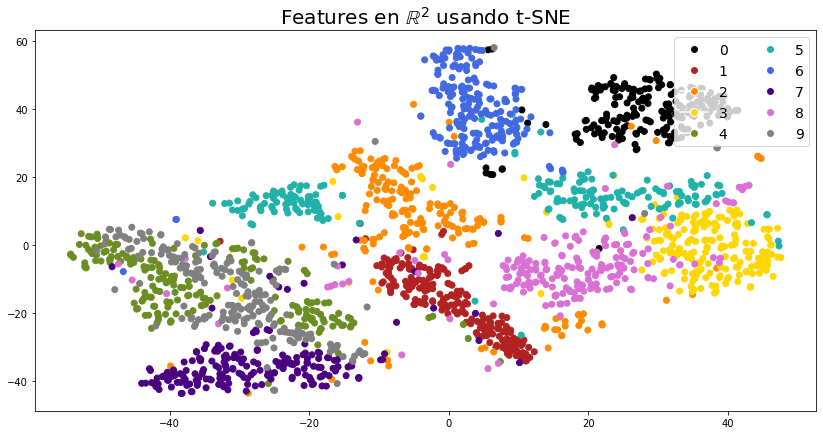

In [48]:
# Voy a mapear cada dígito a un color conocido
colors_dict = {0:'black', 1:'firebrick', 2:'darkorange', 3:'gold', 4:'olivedrab',
               5:'lightseagreen', 6:'royalblue', 7:'indigo', 8:'orchid', 9:'gray'}

target_colors = [colors_dict[label] for label in target_labels]

digits_legend = [Line2D([0], [0], marker='o', color='w', label=str(digit), markerfacecolor=colors_dict[digit], markersize=8) for digit in colors_dict]

# Dibujo
fig, ax = plt.subplots(1,1,figsize=(14, 7))
_= ax.scatter(X_embedded[:,0],X_embedded[:,1],c=target_colors)
_= ax.set_title(r'Features en $\mathbb{R}^2$ usando t-SNE',fontsize=20)
_=ax.legend(handles=digits_legend, loc='upper right',ncol=2,fontsize=14)


Se puede observar que si bien funciona bastante bien, hay muchas instancias difíciles de clasificar en este espacio.
Esto es simplemente para tener una idea de la dificultad del problema, no lo vamos a usar en los métodos.

Para lo que sigue, interpretaremos cada imagen como un nodo de un grafo, e intentaremos aprender las aristas correspondientes, buscando que estas guarden relación con la categoría de cada nodo (es decir, el dígito).
La señal en cada nodo será la imagen vectorizada. Así, si dos imágenes son "parecidas" en algún sentido, estas señales estarán relacionadas, y entonces los nodos estarán conectados por una arista.

Con un poco de suerte, podremos ver las 10 comunidades, que corresponden a los 10 dígitos.

In [49]:
# Estimamos la estructura del grafo usando el método de Meinshausen y Bühlmann
W_meinshausen = meinshausen(Xmnist,alpha=0.00035)

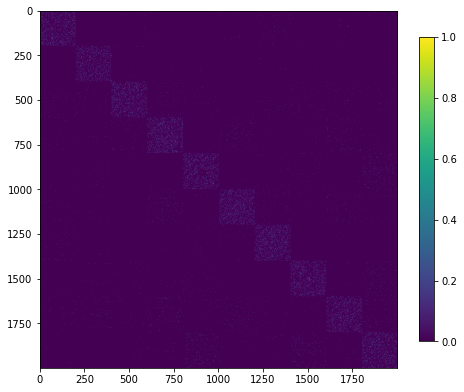

In [50]:
fig_meinshausen, ax_meinshausen = plt.subplots(1,1,figsize=(8,8))
# Y mostramos la estructura de la matriz (los ceros y no ceros)
meinshausen_plot = ax_meinshausen.imshow(W_meinshausen>0)
_=fig_meinshausen.colorbar(mappable=meinshausen_plot,shrink=0.7)

In [51]:
# Veamos esta estructura en el grafo
# Vamos a poner todas las instancias de cada dígito en un círculo, y a su vez los círculos de cada dígito en un círculo más grande.

def draw_learned_digits_graph(weights_matrix,colors_dict=colors_dict,target_colors=target_colors,num_instances_per_class=num_instances_per_class):
  # Armo layout circular con la cantidad de elementos en cada clase
  Gx = nx.from_numpy_array(weights_matrix[0:num_instances_per_class,0:num_instances_per_class])
  posx = nx.circular_layout(Gx)

  data = list(posx.items())
  posx = np.array([data[i][1] for i in range(len(data))])

  # Armo posiciones para el grafo general
  # Son círculos centrados en 2*k*pi/10
  pos = np.zeros((len(target_colors),2))

  digits = list(colors_dict.keys())
  circle_centers = [[5*np.sin(2*d*np.pi/10),5*np.cos(2*d*np.pi/10)] for d in digits ]
  delta_r = 1.4
  text_locs = [[(5+delta_r)*np.sin(2*d*np.pi/10),(5+delta_r)*np.cos(2*d*np.pi/10)] for d in digits ]

  for i in digits:
    pos[i*num_instances_per_class:(i+1)*num_instances_per_class,:] = posx + circle_centers[i]

  # Armo grafo general y dibujo
  G_mb = nx.from_numpy_array(weights_matrix)
  edges = G_mb.edges()
  weights = nx.get_edge_attributes(G_mb, "weight")
  widths = [weights[edge] for edge in edges]
  widths = widths/np.amax(widths,axis=0)

  fig_G, ax_G = plt.subplots(1,1,figsize=(12,12))
  _ = nx.draw_networkx_nodes(G_mb, pos=pos,node_size=4,node_color=target_colors, ax=ax_G)
  _ = nx.draw_networkx_edges(G_mb, width=widths, alpha=0.5, pos=pos, ax=ax_G)

  for idx, text_loc in enumerate(text_locs):
    ax_G.text(text_loc[0], text_loc[1], digits[idx],color=colors_dict[digits[idx]],
              fontsize=26,fontweight='bold',horizontalalignment='center',
              verticalalignment='center')

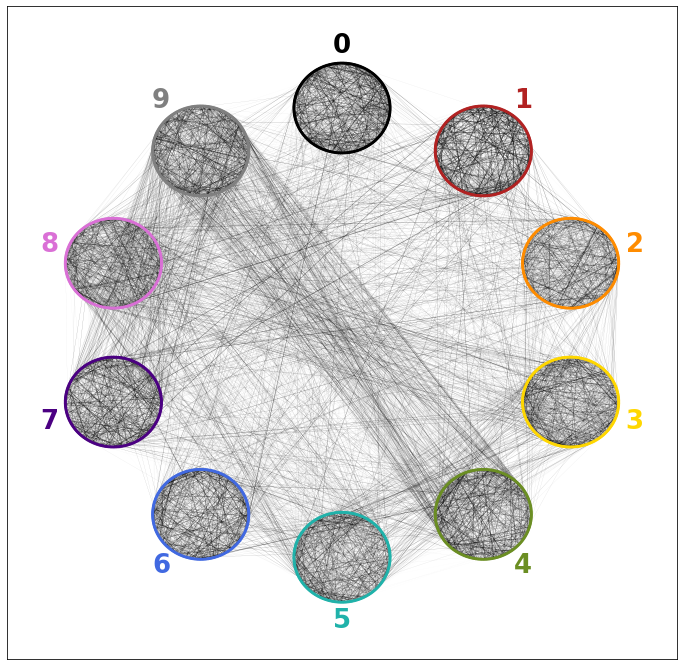

In [52]:
# Armamos el grafo a partir de la matriz resultado, y además coloreamos los nodos según la clase (el dígito), y el ancho de cada arista de acuerdo al peso aprendido con el método.
draw_learned_digits_graph(W_meinshausen)



6.  Comente el resultado. ¿Tiene sentido la estructura encontrada?



Una manera de evaluar el resultado es realizar *spectral clustering* utilizando este grafo aprendido. Esto se hace en el método de sklearn indicando que la matriz de afinidad está precomputada, y es el parámetro que le pasamos al método.
Le indicamos que queremos encontrar 10 clusters, y evaluamos los resultados con tres medidas.


In [53]:
# Hago spectral clustering en el grafo aprendido
spectral_clustering = SpectralClustering(n_clusters=10, affinity="precomputed",n_init=100)

# Uso como medidas de afinidad las entradas positivas de la matriz de pesos aprendida
affinity_matrix_meinshausen = W_meinshausen.copy()
affinity_matrix_meinshausen[affinity_matrix_meinshausen<0] = 0
spectral_clustering.fit(affinity_matrix_meinshausen)

labels_meinshausen = spectral_clustering.labels_.copy()

meinshausen_results =["Meinshausen",metrics.v_measure_score(target_labels,labels_meinshausen),
                     metrics.adjusted_rand_score(target_labels,labels_meinshausen),
                     metrics.fowlkes_mallows_score(target_labels,labels_meinshausen)]

/Users/graciana/personal/AA-grafos/.venv-lab3/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [54]:
# Mostramos los resultados
from IPython.display import display
metrics_df=pd.DataFrame([meinshausen_results],columns=['Método','V-Measure','Rand', 'Fowlkes-Mallows'])

display(metrics_df.style.hide(axis='index'))

Método,V-Measure,Rand,Fowlkes-Mallows
Meinshausen,0.591794,0.322577,0.432388


Si la implementación del método de Meinshausen es correcta, debería dar un valor de V-Measure superior (o del orden) a 0.6.
Pude intentar mejorar este valor cambiando el parámetro de regularización del método.

Probemos ahora con el método de Kalofolias.

In [55]:
# Estimamos la estructura del grafo con el método de Kalofolias
W_kalofolias = lg.log_degree_barrier(normalize(Xmnist.T,axis=1),alpha=3, beta=0.1, step=0.5)

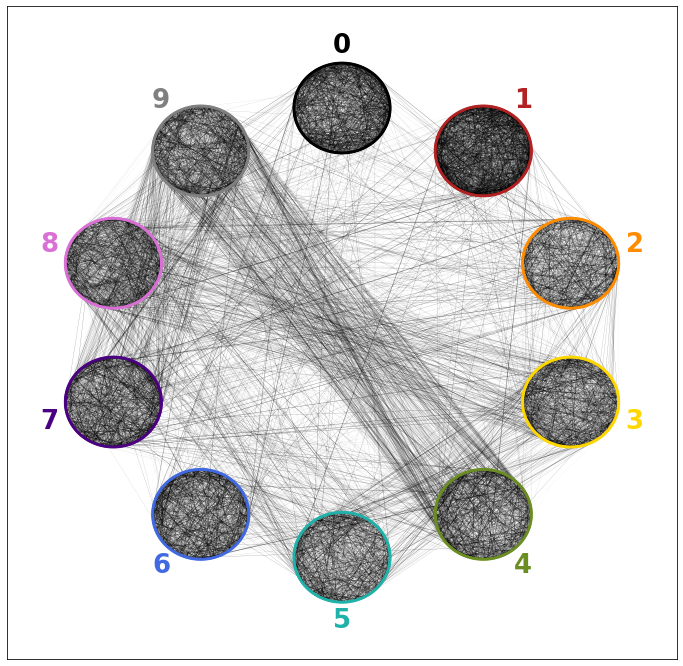

In [56]:
# Umbralizamos los pesos del grafo: nos quedamos solo con los pesos que estén en
# por encima del cuantil 0.99
W_thresh = W_kalofolias.copy()
W_thresh[W_thresh < np.quantile(W_thresh, 0.99)] = 0
draw_learned_digits_graph(W_thresh)

Como arriba, hacemos spectral clustering con el resultado.

También hacemos clustering en el espacio original (es decir, sin aprender ninguna estructura con los métodos vistos), y en el espacio de dimensión 2 obtenido con t-SNE.

In [57]:
# Clustering con Kalofolias
spectral_clustering.fit(W_kalofolias)
labels_kalofolias = spectral_clustering.labels_.copy()

kalofolias_results = ["Kalofolias",metrics.v_measure_score(target_labels,labels_kalofolias),
                      metrics.adjusted_rand_score(target_labels,labels_kalofolias),
                      metrics.fowlkes_mallows_score(target_labels,labels_kalofolias)]

In [58]:
# Clustering en el espacio original
spectral_clustering_features = SpectralClustering(n_clusters=10,affinity='nearest_neighbors',n_init=100)
spectral_clustering_features.fit(Xmnist.T)
labels_X =spectral_clustering_features.labels_

original_space_results = ["Clustering en espacio original",metrics.v_measure_score(target_labels,labels_X),
                          metrics.adjusted_rand_score(target_labels,labels_X),
                          metrics.fowlkes_mallows_score(target_labels,labels_X)]

In [59]:
# Clustering en el espacio de t-SNE
spectral_clustering_features.fit(X_embedded)
labels_tsne =spectral_clustering_features.labels_

tsne_results = ["Clustering con t-SNE",metrics.v_measure_score(target_labels,labels_tsne),
                metrics.adjusted_rand_score(target_labels,labels_tsne),
                metrics.fowlkes_mallows_score(target_labels,labels_tsne)]

In [60]:
# Muestro resultados
results = [original_space_results,meinshausen_results,kalofolias_results,tsne_results]
metrics_df=pd.DataFrame(results,columns=['Método','V-Measure','Rand', 'Fowlkes-Mallows'])

display(metrics_df.style.hide(axis='index'))

Método,V-Measure,Rand,Fowlkes-Mallows
Clustering en espacio original,0.608977,0.414621,0.487145
Meinshausen,0.591794,0.322577,0.432388
Kalofolias,0.704810,0.484090,0.562653
Clustering con t-SNE,0.627884,0.475135,0.532973


Finalmente, comparamos los resultados del clustering de todos los métodos.
Se puede observar que tanto el método de Kalofolias como el de Meinshausen y Bühlmann recuperan una estructura útil. El objetivo de esta parte no es mejorar el resultado de clustering en el espacio original (aunque suceda), sino verificar la estructura obtenida.

En la siguiente celda repetimos el código para generar la visualización después del t-SNE de los datos con las etiquetas correctas.

7. Repita esta visualización para cada método analizado.
8. Enfóquese en el método de Kalofolias, que parece obtener los mejores resultados. ¿Qué instancias clasifica correctamente, para las cuales a su vez el método de hacer clustering en el plano t-SNE falla? Y a la inversa, ¿en qué instancias falla que hacer clustering en el plano t-SNE brinda la solución correcta? Relaciónelo con el grafo que obtuvo cada método.

(3, 2)


Text(0.5, 0.98, 'Features en $\\mathbb{R}^2$ usando t-SNE')

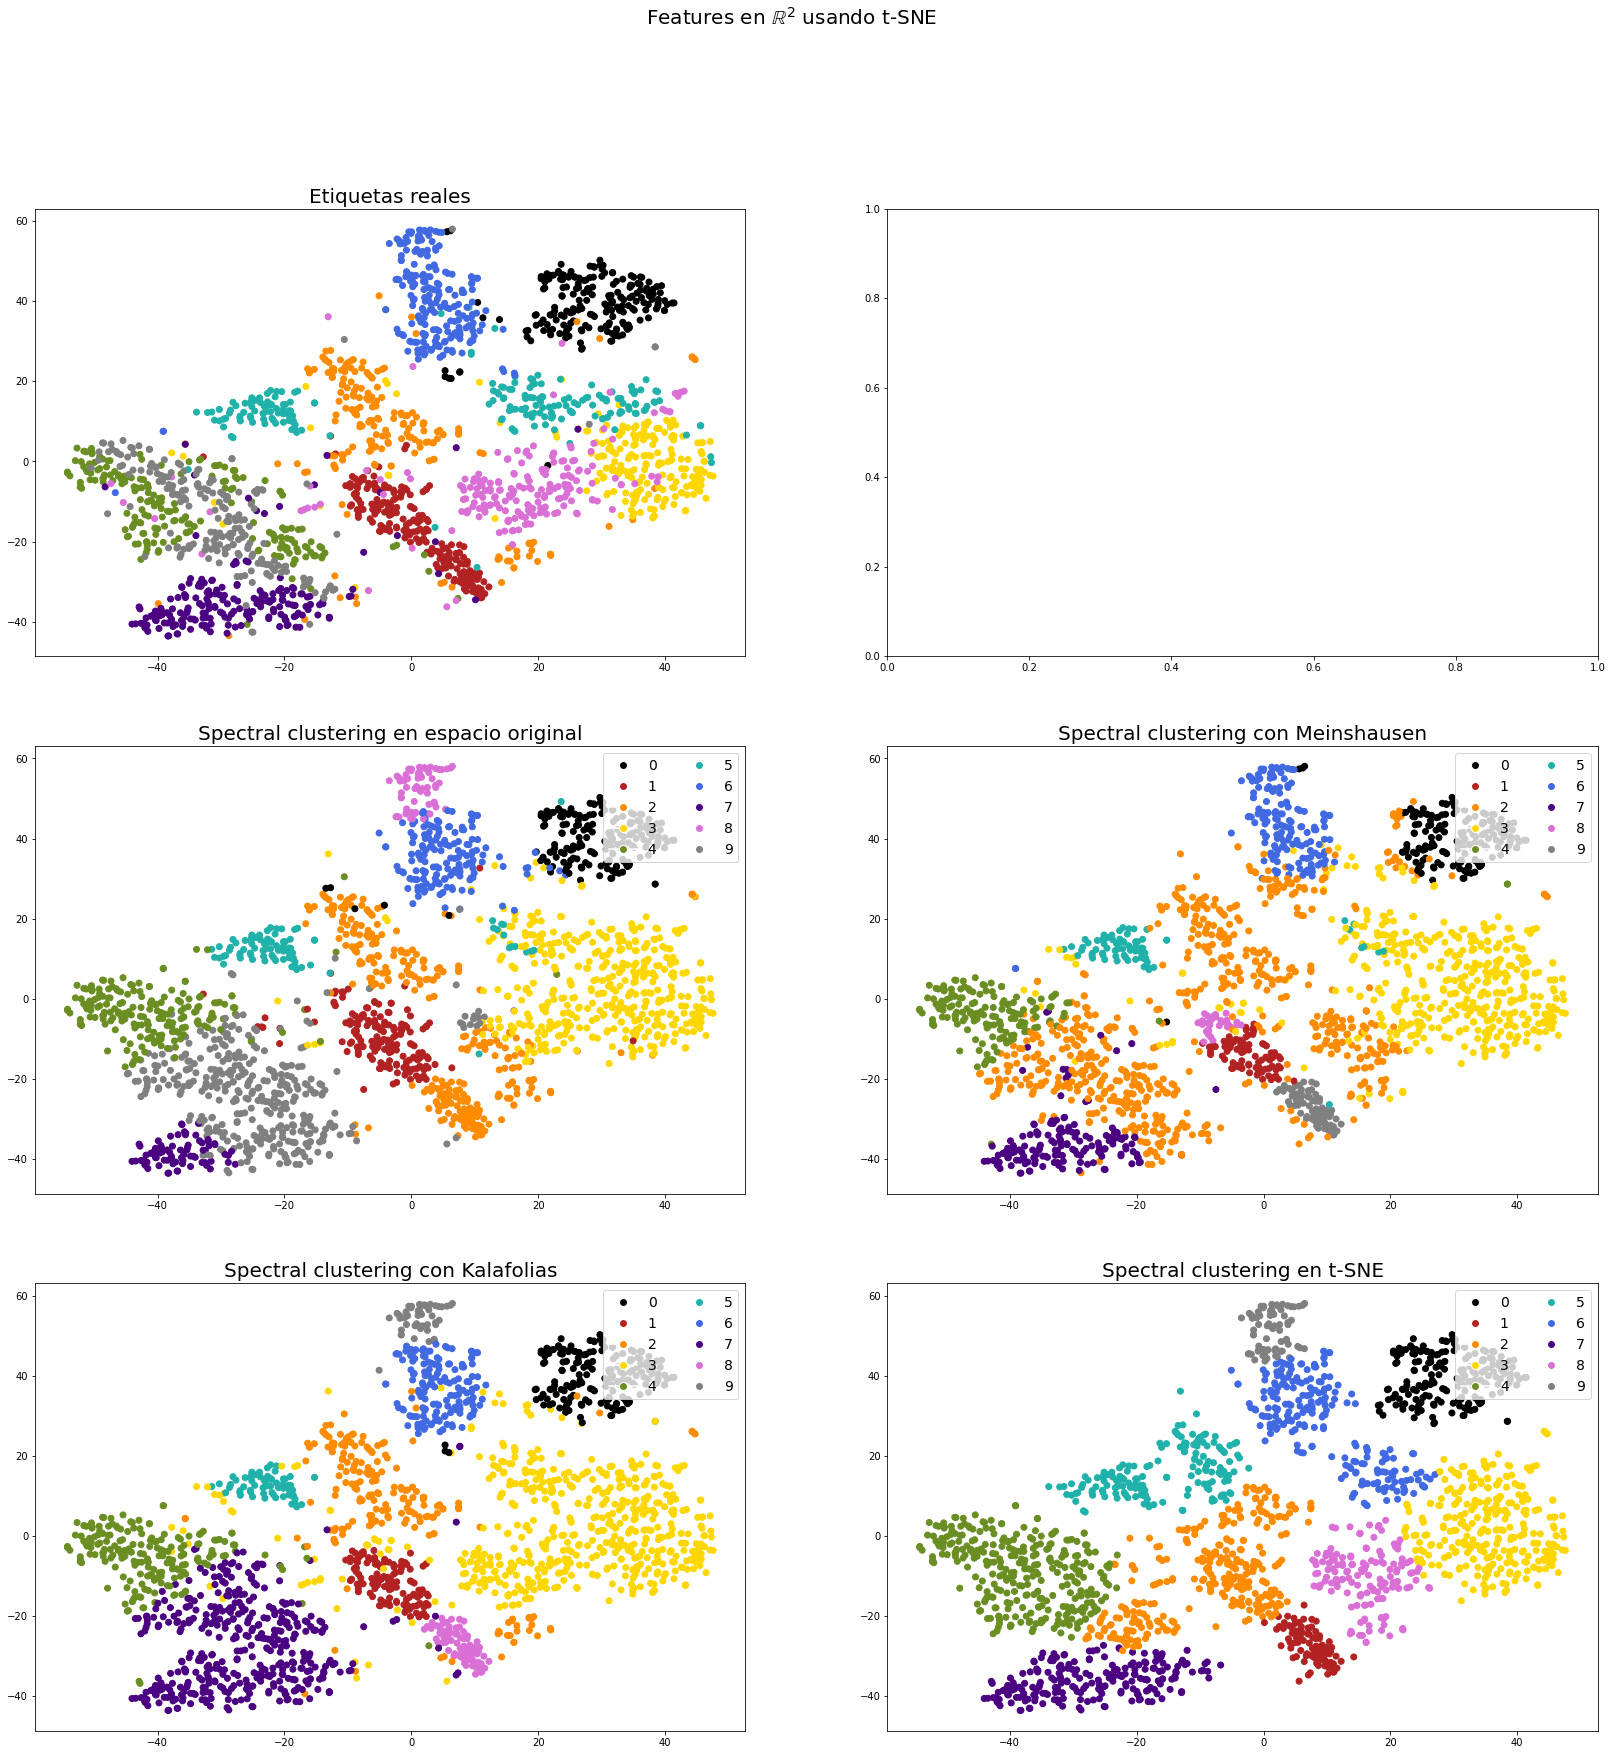

In [61]:
fig, axs = plt.subplots(3,2,figsize=(28, 28))
print(axs.shape)
axs[0,0].scatter(X_embedded[:,0],X_embedded[:,1],c=target_colors)
axs[0,0].set_title('Etiquetas reales',fontsize=20)

################################################################################
# Escriba aquí su código para generar los colores correspondientes a cada método
# Puede ser útil la función remap_labels de graspologic
################################################################################
clustering_original_colors = [colors_dict[label] for label in remap_labels(target_labels, labels_X)]
meinshausen_colors = [colors_dict[label] for label in  remap_labels(target_labels, labels_meinshausen)]
kalofolias_colors = [colors_dict[label] for label in remap_labels( target_labels, labels_kalofolias)]
clustering_t_sne_colors = [colors_dict[label] for label in remap_labels(target_labels, labels_tsne)]


_= axs[1,0].scatter(X_embedded[:,0],X_embedded[:,1],c=clustering_original_colors)
_= axs[1,0].legend(handles=digits_legend, loc='upper right',ncol=2,fontsize=14)
_= axs[1,0].set_title(r'Spectral clustering en espacio original',fontsize=20)


_= axs[1,1].scatter(X_embedded[:,0],X_embedded[:,1],c=meinshausen_colors)
_= axs[1,1].legend(handles=digits_legend, loc='upper right',ncol=2,fontsize=14)
_= axs[1,1].set_title(r'Spectral clustering con Meinshausen',fontsize=20)


_= axs[2,0].scatter(X_embedded[:,0],X_embedded[:,1],c=kalofolias_colors)
_= axs[2,0].legend(handles=digits_legend, loc='upper right',ncol=2,fontsize=14)
_= axs[2,0].set_title(r'Spectral clustering con Kalafolias',fontsize=20)

_= axs[2,1].scatter(X_embedded[:,0],X_embedded[:,1],c=clustering_t_sne_colors)
_= axs[2,1].legend(handles=digits_legend, loc='upper right',ncol=2,fontsize=14)
_= axs[2,1].set_title(r'Spectral clustering en t-SNE',fontsize=20)

fig.suptitle(r'Features en $\mathbb{R}^2$ usando t-SNE',fontsize=20)
